KAGGLE ACTIVATION

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


GET DATA FROM KAGGLE AND STANDFORD

In [3]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 95% 50.0M/52.6M [00:00<00:00, 62.2MB/s]
100% 52.6M/52.6M [00:00<00:00, 58.7MB/s]


In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2022-08-06 16:18:33--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-06 16:18:33--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.06MB/s    in 2m 39s  

2022-08-06 16:21:12 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [4]:
! unzip jigsaw-toxic-comment-classification-challenge.zip
! unzip train.csv.zip

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           
Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
n! unzip glove.6B

Archive:  glove.6B.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of glove.6B or
        glove.6B.zip, and cannot find glove.6B.ZIP, period.


IMPORTS

In [6]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, GlobalMaxPooling1D, LSTM, Embedding, Bidirectional
from keras.models import Model
from sklearn.metrics import roc_auc_score
#area under score is useful for binary classification

GLOBAL VARIABLES

In [7]:
MAX_SEQUENCE_LEN = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [9]:
word2vec = dict()
control = 1
with open(f'/content/drive/MyDrive/Colab Exercises/glove.6B.{EMBEDDING_DIM}d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype=np.float32)
    word2vec[word] = vec
    if control:
      print(f'Line : {line}')
      print(f'Word : {word}')
      print(f'Vec  : {vec}')
      control = 0
print(f'Found {len(word2vec)} word in the document')

Line : the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

Word : the
Vec  : [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  

In [10]:
train = pd.read_csv('train.csv')
train.sample(4)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
74707,c7d7e91da1afd67f,"Can we get this page unlocked, then?",0,0,0,0,0,0
18313,305b3ee7e7771b7d,Pic of the day Wednesday,0,0,0,0,0,0
118100,76e06e34d809590d,"00:20, 2 February 2006",0,0,0,0,0,0
140284,ee9ce469ea159a1c,"At the time of recapture, Ryan had no reason t...",0,0,0,0,0,0


In [11]:
print(f'Check if null values exists:\n{train.isnull().sum()}')
print(f'Check if na values exists:\n{train.isna().sum()}')

Check if null values exists:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Check if na values exists:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [12]:
sentences = train['comment_text'].values
labels = ['toxic', 'severe_toxic',	'obscene','threat',	'insult',	'identity_hate']
targets = train[labels].values
print(f'Shape of target is {targets.shape}')

Shape of target is (159571, 6)


Minimum lenght of sentences is 6
Maximum lenght of sentences is 5000
Mean lenght of sentences is 394.0732213246768
Approximate median lenght of sentences is 205


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


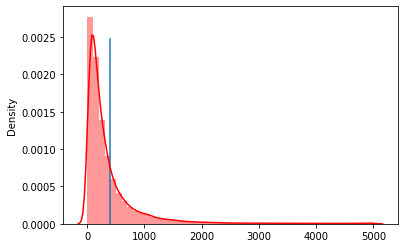

In [14]:
lenghtArray = np.sort( np.array([len(s) for s in sentences]) )
mean = lenghtArray.sum()/len(lenghtArray)
print(f'Minimum lenght of sentences is {np.min(lenghtArray)}')
print(f'Maximum lenght of sentences is {np.max(lenghtArray)}')
print(f'Mean lenght of sentences is { mean }')
print(f'Approximate median lenght of sentences is {lenghtArray[len(lenghtArray)//2]}')
plt.axvline(mean, 0.85,0,label=f'Mean')
sns.distplot(lenghtArray, color = 'red')

In [15]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [16]:
word2idx = tokenizer.word_index
print(f'Len of word2idx is {len(word2idx)}')

Len of word2idx is 210337


In [17]:
data = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LEN)
print(f'Check data shape :> {data.shape} << N x T')

Check data shape :> (159571, 100) << N x T


In [18]:
print('Filling Pretrained Embeddings')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embeddingMatrix = np.zeros((num_words, EMBEDDING_DIM ))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embeddingVectors = word2vec.get(word)
    if embeddingVectors is not None:
      embeddingMatrix[i] = embeddingVectors

Filling Pretrained Embeddings


In [19]:
embedding_layer = Embedding(
    num_words,                      #V
    EMBEDDING_DIM,                  #T
    weights = [embeddingMatrix],    #transfer learning part
    input_length = MAX_SEQUENCE_LEN, #
    trainable = False
)

In [20]:
i = Input(shape = (MAX_SEQUENCE_LEN,))        
el = embedding_layer(i)
lstm = LSTM(10, return_sequences=True)(el)
gmax = GlobalMaxPooling1D()(lstm)
output = Dense(len(labels),activation='sigmoid')(gmax)

In [28]:
i = Input(shape = (MAX_SEQUENCE_LEN,))        
el = embedding_layer(i)
lstm = Bidirectional(LSTM(10, return_sequences=True))(el)
gmax = GlobalMaxPooling1D()(lstm)
output = Dense(len(labels),activation='sigmoid')(gmax)

In [29]:
model = Model(i, output)
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [30]:
r = model.fit(
    data, targets, batch_size=BATCH_SIZE, 
    epochs = EPOCHS, validation_split= VALIDATION_SPLIT
    )

Epoch 1/10
998/998 [==============================] - 84s 80ms/step - loss: 0.1245 - accuracy: 0.7781 - val_loss: 0.0632 - val_accuracy: 0.9940
Epoch 2/10
998/998 [==============================] - 77s 77ms/step - loss: 0.0597 - accuracy: 0.9939 - val_loss: 0.0579 - val_accuracy: 0.9935
Epoch 3/10
998/998 [==============================] - 80s 80ms/step - loss: 0.0554 - accuracy: 0.9931 - val_loss: 0.0563 - val_accuracy: 0.9928
Epoch 4/10
998/998 [==============================] - 80s 80ms/step - loss: 0.0532 - accuracy: 0.9922 - val_loss: 0.0544 - val_accuracy: 0.9919
Epoch 5/10
998/998 [==============================] - 78s 78ms/step - loss: 0.0516 - accuracy: 0.9907 - val_loss: 0.0533 - val_accuracy: 0.9921
Epoch 6/10
998/998 [==============================] - 80s 80ms/step - loss: 0.0505 - accuracy: 0.9865 - val_loss: 0.0526 - val_accuracy: 0.9877
Epoch 7/10
998/998 [==============================] - 80s 80ms/step - loss: 0.0496 - accuracy: 0.9826 - val_loss: 0.0517 - val_accuracy:

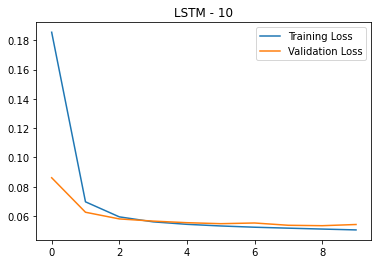

In [26]:
plt.title('LSTM - 10')
plt.plot(r.history['loss'], label = 'Training Loss')
plt.plot(r.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

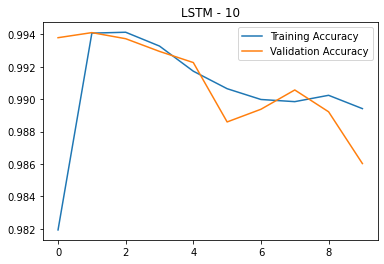

In [27]:
plt.title('LSTM - 10')
plt.plot(r.history['accuracy'], label = 'Training Accuracy')
plt.plot(r.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

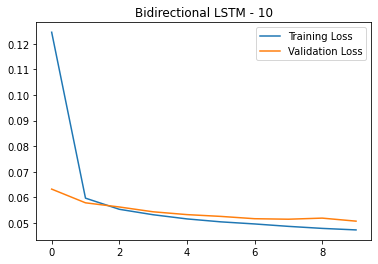

In [31]:
plt.title('Bidirectional LSTM - 10')
plt.plot(r.history['loss'], label = 'Training Loss')
plt.plot(r.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

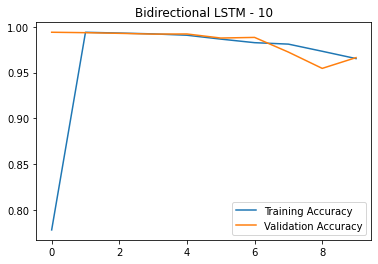

In [32]:
plt.title('Bidirectional LSTM - 10')
plt.plot(r.history['accuracy'], label = 'Training Accuracy')
plt.plot(r.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

In [33]:
p = model.predict(data)
aucs = []
for i in range(6):
  auc = roc_auc_score( targets[:,i], data[:,i] )
  aucs.append(auc)
print(np.mean(aucs))

0.460302438216096
